# Word Vectors

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




# Importamos Librerias para todo el trabajo

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import keras
from keras.datasets import imdb

Using TensorFlow backend.


# Bajamos y armamos el DataSet

In [30]:
## Bajamos el IMDB dataset y armamos el dataset

NUM_WORDS=1000 # Cantidad de palabras a utilizar
INDEX_FROM=3   # offset para las primeras palabras

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=NUM_WORDS,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=INDEX_FROM)

word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}

word_to_id["<PAD>"]   = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"]   = 2

id_to_word = {value:key for key,value in word_to_id.items()}

ds_trn = {'input': x_train,
          'target': y_train}

ds_tst = {'input':  x_test,
          'target': y_test}

# Visualizamos el dataset

 - Datos TRAIN:   input_shape=(25000,) target_shape=(25000,)
 - Datos TEST :   input_shape=(25000,) target_shape=(25000,)


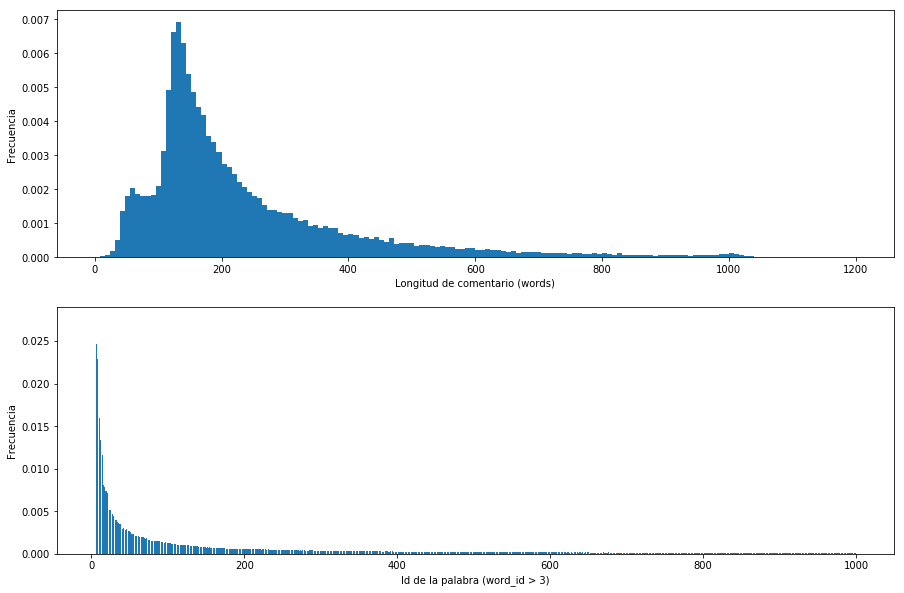

In [83]:
# Mostramos el contenido
print(' - Datos TRAIN:   input_shape={} target_shape={}'.format(ds_trn['input'].shape, ds_trn['target'].shape))
print(' - Datos TEST :   input_shape={} target_shape={}'.format(ds_tst['input'].shape, ds_tst['target'].shape))

len_v = []
freq_c = Counter()
for ds in [ds_trn['input'], ds_tst['input']]:
    for v in ds:
        len_v.append( len(v) )
        w_id_v, count_v = np.unique(v, return_counts=True)
        for w_id, count in zip(w_id_v, count_v):
            freq_c[w_id] += count
            s
len_v  = np.array(len_v)
freq_a = np.array( sorted( freq_c.items() ), dtype=np.float)
freq_a[:,1] = freq_a[:,1]/freq_a[:,1].sum()



f,axes = plt.subplots(2,1, figsize=(15,10))

ax = axes[0]
ax.hist(len_v, bins=150, normed=True, range=(0,1200))
ax.set_xlabel('Longitud de review (words)')
ax.set_ylabel('Frecuencia')


ax = axes[1]
ax.bar(freq_a[3:,0], freq_a[3:,1])
ax.set_xlabel('Id de la palabra (word_id > 3)')
ax.set_ylabel('Frecuencia')

plt.show()


## Comentarios:
- Se cargó el dataset de IMDB con las 1000 palabras de mayor recuencia
- El dataset de train y test cuenta con 25000 reviews cada uno.
- De la gráfica de la distribución de longitud de review, podemos ver que al elegir una longitud de secuencia mayores que 400 palabras, conservamos la mayoría de los comentarios completos. Para 400 palabras conservamos el 86% de las secuencuas completas. Para 600 conservamos el 95% de las secuencias completas.
- La grafica de frecuencia de palabras nos muestra que la elección de las 1000 palabras más relevantes deja una cola en la distribución de frecuencias de palabras muy pequeña (< 9.93e-05).
- Se agregaron 3 ids especiales **< PAD >** para completar las secuencias cortas, **< UNK >** para palabras desconocidas de menor frecuenca que no fueron cargadas del dataset, y **< START >** para marcar el inicio de una nueva review.

In [87]:
(len_v < 600).mean()

0.9506

In [35]:
freq_a[4]

array([6, 0], dtype=int64)

In [16]:
freq_c[20]

87050